In [55]:
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [124]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset2 = torchvision.datasets.ImageFolder(root='d1', transform=transform)
trainset1 = torchvision.datasets.ImageFolder(root='d2', transform=transform)

In [210]:
trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size=2, shuffle=False, pin_memory=True)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=2, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='test_demo', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [185]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [200]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        n_classes = 39
        
        hidden_1 = 1024
        hidden_2 = 256
        
        self.fc1 = nn.Linear(9216, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, n_classes)
        
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 9216)
        
        y = F.relu(self.fc1(x))
        y = self.dropout(y)
        y = F.relu(self.fc2(y))
        y = self.dropout(y)
        y = self.fc3(y)
        
        z = F.relu(self.fc1(x))
        z = self.dropout(z)
        z = F.relu(self.fc2(z))
        z = self.dropout(z)
        z = self.fc3(z)
        
        return y,z

net = torchvision.models.alexnet(pretrained=True)

for param in net.parameters():
    param.requires_grad = False
net.classifier = Net()
net.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Net(
    (fc1): Linear(in_features=9216, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_featu

In [201]:
# net = torchvision.models.alexnet(pretrained=False)
# net = net.to(device)

In [202]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

In [211]:
valid_loss_min=np.Inf
train_loss_plt=[]
valid_loss_plt = []
valid_accuracy_plt=[]
valid_loss = []
for epoch in range(1):
    train_loss=0
    valid_loss=0
    
#     net.train()
#     for (data1, data2) in zip(trainloader1, trainloader2):
#         images, labels1 = data1
#         _, labels2 = data2
#         images, labels1 = images.to(device), labels1.to(device)
#         labels2 = labels2.to(device)
#         optimizer.zero_grad()
#         output1, output2 = net(images)
#         loss_leaf = criterion(output1, labels1)
#         loss_disease = criterion(output2, labels2)
#         loss_leaf.backward()
#         loss_disease.backward()
#         optimizer.step()
#         train_loss += loss_disease.item() * images.size(0)
    
    net.eval()
    for images, labels in testloader:
        images, labels= images.cuda(), labels.cuda()
        output, _ = net(images)
        _, pred = torch.max(output,1)
        print (labels, pred+1)
        ps=torch.exp(output)
        loss = criterion(output, labels)
        valid_loss += loss.item() * images.size(0)
        
    train_loss /= len(trainloader1)
    valid_loss /= len(testloader)
    train_loss_plt.append(train_loss)
    valid_loss_plt.append(valid_loss)

    #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

tensor([1], device='cuda:0') tensor([1], device='cuda:0')
tensor([2], device='cuda:0') tensor([2], device='cuda:0')
tensor([3], device='cuda:0') tensor([4], device='cuda:0')


<!-- # import joblib
joblib.dump(train_loss_plt, 't.joblib')
joblib.dump(valid_loss_plt, 'v.joblib') -->

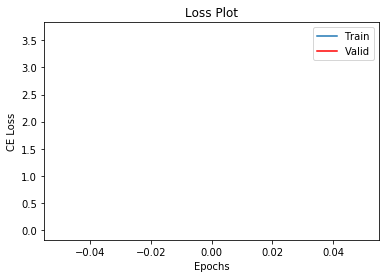

In [160]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_loss_plt)), train_loss_plt,label='Train')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# plt.legend()
# plt.show()
plt.plot(np.arange(len(valid_loss_plt)),valid_loss_plt,label='Valid',color='r')
# plt.title('Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('CE Loss')
plt.legend()
plt.show()

In [161]:
accuracy=0

with torch.no_grad():
    net.eval()
    for images, labels in testset:
        images, labels = images.cuda(), labels.cuda()
        output, _=net(images)
        ps=torch.exp(output)
        top_p, top_class=ps.topk(1, dim=1)

        equals= top_class==labels.view(*top_class.shape)
        accuracy+=torch.mean(equals.type(torch.FloatTensor))
    
print("Test Accuracy: {:.3f}".format(accuracy/len(testset)))

AttributeError: 'int' object has no attribute 'cuda'